In [1]:
from scipy.spatial.distance import cdist
import scipy.io as sio
import matplotlib.pyplot as plt
from config import *

category = 'bus'
set_type = 'train'
pool_patch_r = 3
back_per_instance = 3
# get magic_threshold
thrh_file = os.path.join(Model_dir,'magic_thh_{}_{}.pickle'.format(set_type,VC['layer']))
with open(thrh_file, 'rb') as fh:
    thrh_ls = pickle.load(fh)
    
magic_thrh = thrh_ls[all_categories2.index(category)]

# get file list
filelist = Dataset['{}_list'.format(set_type)].format(category)
with open(filelist, 'r') as fh:
    contents = fh.readlines()

img_list = [cc.strip().split()[0] for cc in contents if cc != '\n']
idx_list = [cc.strip().split()[1] for cc in contents if cc != '\n']

N = len(img_list)
print('Total image number for {} set of {}: {}'.format(set_type, category, N))

# read in VC centers
with open(Dict['Dictionary'].format(category),'rb') as fh:
    centers = pickle.load(fh)

# get instance features and encode into 0/1
file_feat = os.path.join(Feat['cache_dir'], 'feat_{}_{}_{}.pickle'.format(category, set_type, VC['layer']))
with open(file_feat, 'rb') as fh:
    layer_feature = pickle.load(fh)
    
assert(N == len(layer_feature))

r_set = [None for nn in range(N)]
for nn in range(N):
    iheight,iwidth = layer_feature[nn].shape[0:2]
    lff = layer_feature[nn].reshape(-1, featDim)
    lff_norm = lff/np.sqrt(np.sum(lff**2, 1)).reshape(-1,1)
    r_set[nn] = cdist(lff_norm, centers, 'cosine').reshape(iheight,iwidth,-1)

layer_feature_b = [None for nn in range(N)]
for nn in range(N):
    layer_feature_b[nn] = (r_set[nn]<magic_thrh).astype(int)
    
print('Done')

Total image number for train set of bus: 517
Done


In [3]:

feature_len = VC['num']*(2*pool_patch_r+1)**2
all_info = [None for nn in range(N)]

for nn in range(N):
    if nn%100==0:
        print(nn)
#     image_f = os.path.join(Dataset['img_dir'].format(category), '{}_{}.JPEG'.format(img_list[nn], idx_list[nn]))
#     img=cv2.imread(image_f)
#     plt.imshow(img[:,:,::-1])
#     plt.show()
    lfb = layer_feature_b[nn]
    height, width = lfb.shape[0:2]
    padded = np.pad(lfb, ((pool_patch_r,pool_patch_r),(pool_patch_r,pool_patch_r),(0,0)), 'constant')
    
    anno_file = os.path.join(Dataset['sp_anno_dir'].format(category), '{}.mat'.format(img_list[nn]))
    matcontent = sio.loadmat(anno_file)
    sp_num = matcontent['anno'][int(idx_list[nn])-1,1].shape[0]
    # assert(sp_num == 39)
    instance_info = [None for mm in range(sp_num+1)]
    
    cover_msk = np.zeros((height, width))
    
    for mm in range(sp_num):
        sn_check = matcontent['anno'][int(idx_list[nn])-1,1][mm,0].shape[1]
        if sn_check>0 and sn_check!=9:
            print(nn,mm, matcontent['anno'][int(idx_list[nn])-1,1][mm,0].shape)
            spi_num=0
        else:
            spi_num = matcontent['anno'][int(idx_list[nn])-1,1][mm,0].shape[0]
            
        sp_info = [None for kk in range(spi_num)]
        for kk in range(spi_num):
            # print(nn,mm,kk)
            spi_box = matcontent['anno'][int(idx_list[nn])-1,1][mm,0][kk]
#             print(spi_box[0:4])
#             spi_patch = img[int(max(spi_box[1],0)):int(spi_box[3]), int(max(spi_box[0],0)):int(spi_box[2])]
#             plt.imshow(spi_patch[:,:,::-1])
#             plt.show()
            
            xy = (spi_box[0:2]+spi_box[2:4])/2-1
            pool_xy = (xy//Astride).astype(int)
            try:
                pool_xy[0] < 0
            except:
                print(img_list[nn], idx_list[nn], matcontent['anno'][int(idx_list[nn])-1,1][mm,0])
                
            if pool_xy[0] < 0:
                # print(xy[0],pool_xy[0])
                pool_xy[0] = 0
            if pool_xy[0] > width - 1:
                # print(xy[0], pool_xy[0], width - 1)
                pool_xy[0] = width - 1
            if pool_xy[1] < 0:
                # print(xy[1],pool_xy[1])
                pool_xy[1] = 0
            if pool_xy[1] > height - 1:
                # print(xy[1], pool_xy[1], height - 1)
                pool_xy[1] = height - 1
                
            sp_info[kk] = np.copy(padded[pool_xy[1]: pool_xy[1]+(2*pool_patch_r+1),\
                                         pool_xy[0]: pool_xy[0]+(2*pool_patch_r+1)].ravel())
            
            assert(len(sp_info[kk])==feature_len)
            
            cover_msk[max(0,int(pool_xy[1]-pool_patch_r)):min(height,int(pool_xy[1]+pool_patch_r+1)),\
                      max(0,int(pool_xy[0]-pool_patch_r)):min(width,int(pool_xy[0]+pool_patch_r+1))] = 1
            
        instance_info[mm] = sp_info
        
    
    
    bg_r,bg_c = np.where(cover_msk==0)
    if len(bg_r) > back_per_instance:
        bg_select = np.random.choice(len(bg_r), size=(back_per_instance,), replace=False)
    else:
        bg_select = np.array(range(len(bg_r)))
        
    bg_info = [None for bb in range(len(bg_select))]
    for bgi, bg_idx in enumerate(bg_select):
        bg_rr = bg_r[bg_idx]
        bg_cc = bg_c[bg_idx]
        
        bg_info[bgi] = np.copy(padded[bg_rr: bg_rr+(2*pool_patch_r+1),bg_cc:bg_cc+(2*pool_patch_r+1)].ravel())
    
    instance_info[sp_num] = bg_info
    
    all_info[nn] = instance_info
    
print('Done')


0
100
200
300
400
500
Done


In [4]:
spi_box

array([ -32.34468665,   23.81743869,   67.65531335,  123.81743869,
        -39.27132396,  139.49068217,  122.3358189 ,  301.09782503,   10.        ])

In [3]:
save_name = os.path.join(VCencode_dir, 'SP_{}_encoding_{}.pickle'.format(VC['layer'], category))
with open(save_name,'wb') as fh:
    pickle.dump(all_info, fh)
    
print('done')

done


In [4]:
print([len(all_info[0][pp]) for pp in range(40)])

[2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 4]


In [12]:
all_info[0][11][0].shape

(7350,)

In [14]:
print([np.sum(ff) for ff in all_info[0][39]])

[5, 9, 30, 59]


In [1]:
from config import *

category = 'car'
vc_file = os.path.join(VCencode_dir, 'SP_{}_encoding_{}.pickle'.format(VC['layer'], category))
with open(vc_file,'rb') as fh:
    all_info = pickle.load(fh)
    
N = len(all_info)
print('Total image number of {}: {}'.format(category, N))
sp_num = len(all_info[0])
assert(np.all([len(ff)==sp_num for ff in all_info])) # all have the same sp num

feature_len = VC['num']*(2*SP['patch_r']+1)**2
sp_fires = [np.zeros(feature_len) for pp in range(sp_num)]
sp_cnt = np.zeros(sp_num)

for nn in range(N):
    if nn%100==0:
        print(nn)
    
    for pp in range(sp_num):
        spi_cnt = len(all_info[nn][pp])
        sp_cnt[pp]+=spi_cnt
        
        for ii in range(spi_cnt):
            sp_fires[pp]+=all_info[nn][pp][ii]
            
print(sp_cnt)

Total image number of car: 2000
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
[ 3279.  3080.  3099.  2913.  2935.  3048.  2991.  3071.  3027.  2383.
  1645.  2498.  1694.  2464.  1715.  2348.  2090.   771.   683.   361.
  1199.   445.   410.  1236.  1136.   936.   777.   662.   551.   583.
   543.   557.   660.   635.   642.   592.   541.   184.   188.  5929.]


In [2]:
sp_models = [None for pp in range(sp_num)]
for pp in range(sp_num):
    freq = sp_fires[pp].astype(float)/sp_cnt[pp]+1e-4
    weights = np.log(freq/(1-freq))
    Z = np.sum(np.log(1.0/(1.0-freq)))
    sp_models[pp] = (weights, Z)
    
print('done')

donw


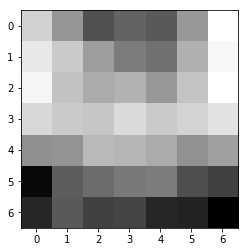

In [13]:
import matplotlib.pyplot as plt

cube = sp_models[39][0].reshape(7,7,150)

plt.imshow(cube[:,:,4], cmap='gray')
plt.show()

In [ ]:
model_file = os.path.join(Model_dir, 'Unary_{}_{}.pickle'.format(VC['layer'], category))
with open(model_file,'wb') as fh:
    pickle.dump(sp_models, fh)

In [23]:
np.inf

inf

In [14]:
np.unravel_index(range(12), (3,4))

(array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]),
 array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]))

In [17]:
np.array([[0,1,2,3],[4,5,6,7],[8,9,10,11]]).ravel()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [5]:
np.concatenate((np.zeros(3),np.ones(3)), axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [8]:
'abc{:3.1f}'.format(0.66666)

'abc0.7'